# Prediction of the flow

### Decision tree regression with the rainfall feature
Model trained on the historical values of the flow, the value of the recent rainfall and/or value from previous hour

### Importing necessary libraries

In [1]:
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import datetime as dt
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4

### Loading the data sets

#### Rainfall data set

In [2]:
rainfall_set = pd.read_csv('../dataset/rainfall1.csv', parse_dates={'hour':['time']},index_col='hour')
dayfirst=True
rainfall_set = rainfall_set.resample('60T').mean()

In [3]:
rainfall_set = rainfall_set.reset_index()

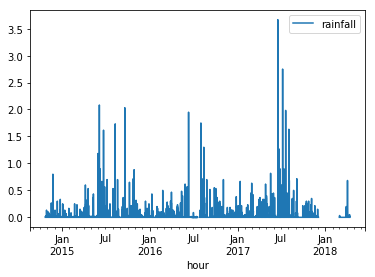

In [4]:
rainfall_set.set_index(['hour']).plot()
plt.show()

In [5]:
rainfall_set = rainfall_set.reset_index()

#### Giving the range of the data '2015-06-01' - '2017-11-10'

In [6]:
rainfall_set = rainfall_set[(rainfall_set['hour'] > '2015-06-01') & (rainfall_set['hour'] <= '2017-11-10')]

In [7]:
rainfall_set = rainfall_set.drop('index', axis=1)

In [8]:
rainfall_set.columns = ['time','rainfall']

#### Creating flow data set

In [9]:
flow_set = pd.read_csv('../dataset/flow1.csv', parse_dates={'hour':['time']},index_col='hour')
dayfirst=True
flow_set = flow_set.resample('60T').mean()

In [10]:
flow_set = flow_set.reset_index()

In [11]:
flow_set['time'] = flow_set['hour']

#### Leaving only a full hour as a feature

In [12]:
flow_set['hour'] = (flow_set['hour'].dt.hour)

In [13]:
flow_set.head()

,hour,flow,time
0,14,113.754443,2015-06-01 14:00:00
1,15,113.013333,2015-06-01 15:00:00
2,16,114.081666,2015-06-01 16:00:00
3,17,116.459167,2015-06-01 17:00:00
4,18,123.825000,2015-06-01 18:00:00


### Merging two data sets into one 
Merging is based on time column

In [14]:
flow_set = pd.merge(flow_set, rainfall_set, how='left', on='time')

In [15]:
flow_set.head()

,hour,flow,time,rainfall
0,14,113.754443,2015-06-01 14:00:00,0.000000
1,15,113.013333,2015-06-01 15:00:00,0.000000
2,16,114.081666,2015-06-01 16:00:00,0.000000
3,17,116.459167,2015-06-01 17:00:00,0.016667
4,18,123.825000,2015-06-01 18:00:00,0.000000


### Adding the feature of previous hour's flow value

In [16]:
flow_set['previous-hour'] = flow_set['flow'].shift(1)

In [17]:
flow_set.head()

,hour,flow,time,rainfall,previous-hour
0,14,113.754443,2015-06-01 14:00:00,0.000000,NaN
1,15,113.013333,2015-06-01 15:00:00,0.000000,113.754443
2,16,114.081666,2015-06-01 16:00:00,0.000000,113.013333
3,17,116.459167,2015-06-01 17:00:00,0.016667,114.081666
4,18,123.825000,2015-06-01 18:00:00,0.000000,116.459167


# Tree regression on two features
The features are the current hour and the rainfall from previous hour

### Adding a column with value of the rainfall from previous hour

In [19]:
flow_set['previous-rainfall'] = flow_set['rainfall'].shift(1)

### Dealing with missing values by filling with the mean

In [20]:
flow_set = flow_set.fillna(flow_set.mean())

### Checking if there are any NaN values left

In [21]:
null_columns=flow_set.columns[flow_set.isnull().any()]
flow_set[null_columns].isnull().sum()

Series([], dtype: float64)

### Splitting the data set into train and test sets

In [22]:
split_date = pd.datetime(2016,12,31,23,59)

flow_training = flow_set.loc[flow_set['time'] <= split_date]
flow_test = flow_set.loc[flow_set['time'] > split_date]

### Creating training and test variables

In [23]:
X_flow_training = flow_training[['hour','previous-rainfall']]
X_flow_test = flow_test[['hour','previous-rainfall']]
Y_flow_training = flow_training['flow']
Y_flow_test = flow_test['flow']

In [24]:
flow_training.head()

,hour,flow,time,rainfall,previous-hour,previous-rainfall
0,14,113.754443,2015-06-01 14:00:00,0.000000,109.165265,0.008585
1,15,113.013333,2015-06-01 15:00:00,0.000000,113.754443,0.000000
2,16,114.081666,2015-06-01 16:00:00,0.000000,113.013333,0.000000
3,17,116.459167,2015-06-01 17:00:00,0.016667,114.081666,0.000000
4,18,123.825000,2015-06-01 18:00:00,0.000000,116.459167,0.016667


In [25]:
flow_test.head()

,hour,flow,time,rainfall,previous-hour,previous-rainfall
13906,0,94.330833,2017-01-01 00:00:00,0.0,99.808334,0.016667
13907,1,91.927501,2017-01-01 01:00:00,0.0,94.330833,0.000000
13908,2,90.722501,2017-01-01 02:00:00,0.0,91.927501,0.000000
13909,3,87.402501,2017-01-01 03:00:00,0.0,90.722501,0.000000
13910,4,81.485833,2017-01-01 04:00:00,0.0,87.402501,0.000000


### Creating a multiple regression model with decision tree

In [26]:
regressor = DecisionTreeRegressor()
regressor.fit(X_flow_training, Y_flow_training)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [27]:
predict = regressor.predict(X_flow_test)

### Plot of the fragment of the model showing only the hour

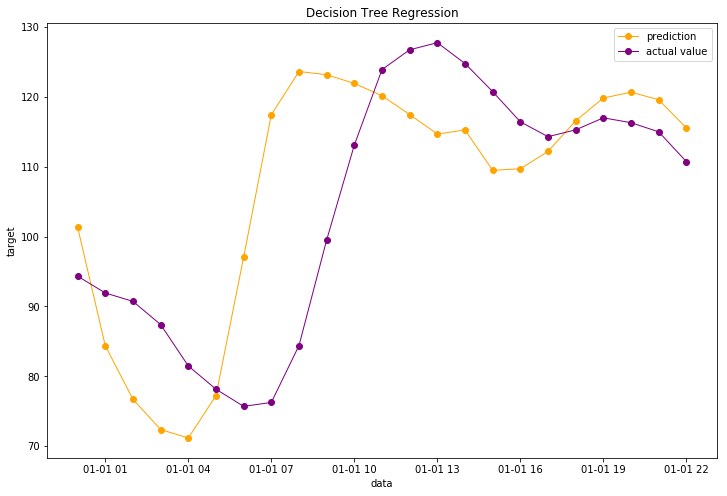

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(flow_test['time'][:23], predict[:23], color="orange",
         marker="o",label="prediction", linewidth=1)
plt.plot(flow_test['time'][:23],Y_flow_test[:23], c='purple',marker="o", label="actual value",linewidth=1)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### Feature_importances_
The importance in the model of the feature hour and the feature previous rainfall value

In [29]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
0,0.96035
1,0.03965


### Implementing metrics (mean absolute percentage error)

In [30]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### MAPE for tree regression with two features

In [31]:
mape_tree = mean_absolute_percentage_error(Y_flow_test, predict)
mape_tree

8.94174243873135

# Tree regression on three features

### Splitting the data set to train and test test

In [32]:
split_date = pd.datetime(2016,12,31,23,59)

flow_training2 = flow_set.loc[flow_set['time'] <= split_date]
flow_test2 = flow_set.loc[flow_set['time'] > split_date]

flow_training2 = flow_training2.fillna(flow_training2.mean())
flow_test2 = flow_test2.fillna(flow_test2.mean())

In [33]:
X_flow_training2 = flow_training2[['hour','previous-hour','previous-rainfall']]
Y_flow_training2 = flow_training2['flow']
X_flow_test2 = flow_test2[['hour','previous-hour','previous-rainfall']]
Y_flow_test2 = flow_test2['flow']

### Creating a multiple regression model with decision tree

In [34]:
regressor2 = DecisionTreeRegressor()
regressor2.fit(X_flow_training2, Y_flow_training2)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [35]:
predict2 = regressor2.predict(X_flow_test2)

### Plot of the fragment of the model showing only the hour

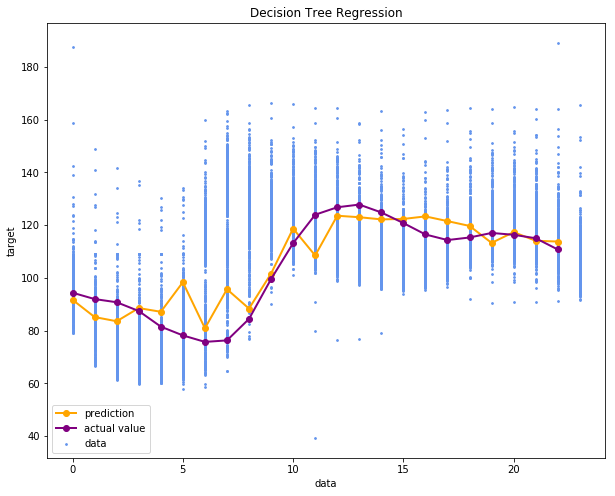

In [36]:
plt.figure(figsize=(10, 8))
plt.scatter(X_flow_training2['hour'], Y_flow_training2, s=3, 
            c="cornflowerblue", label="data")
plt.plot(X_flow_test2['hour'][:23], predict2[:23], color="orange",
         marker="o",label="prediction", linewidth=2)
plt.plot(X_flow_test2['hour'][:23],Y_flow_test2[:23], c='purple',marker="o", label="actual value",linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

### MAPE for tree regression for three features

In [37]:
feature_importances = pd.DataFrame(regressor2.feature_importances_,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
0,0.668164
1,0.326487
2,0.005349


In [38]:
mape_tree2 = mean_absolute_percentage_error(Y_flow_test2, predict2)
mape_tree2

3.8242361787957617

# Comparison with neural network

### Creating a model
MLPRegressor() from sklearn.neural_network

In [39]:
X = X_flow_training2[['hour','previous-hour','previous-rainfall']]
y = Y_flow_training2
test_x = X_flow_test2[['hour','previous-hour','previous-rainfall']]
test_y = Y_flow_test2
    
nn = MLPRegressor()
n = nn.fit(X, y.ravel())
predict_y = nn.predict(test_x)

### Plotting the fragment of the results showing only the hour feature

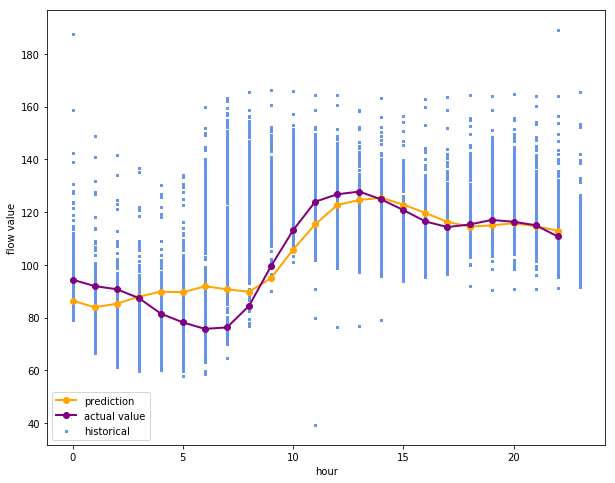

In [40]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(111)

plt.xlabel("hour")
plt.ylabel("flow value")

ax1.scatter(X['hour'], y, s=3, color="cornflowerblue", marker="s", label='historical')
plt.plot(test_x['hour'][:23],predict_y[:23], color='orange', marker="o", label="prediction",linewidth=2)
plt.plot(test_x['hour'][:23],test_y[:23], c='purple', marker="o", label="actual value",linewidth=2)
plt.legend()
plt.show()

### MAPE for the neural network

In [41]:
mape_neural = mean_absolute_percentage_error(Y_flow_test, predict_y)
mape_neural

4.34776424575587